# COVID hatása New York taxiforgalmára

In [3]:
#a kód fordításához szükséges könyvtárak importálása
import pandas as pd
import glob
import os
import shapefile
import datashader as ds, colorcet as cc
import datetime as dt
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

# Data Model
Az adatelemzés során a 2018-as év és a 2020-as év márciusi hónapját vetettük össze. Azért választottuk a márciust mert 2020-ban akkor tetőzött a COVID fertőzések száma New Yorkban.

Valamint ezen két táblán kívül felhasználtunk egy Lookup táblát amiben a LocationID-khoz kaptuk meg, hogy melyik zónába tartozik.
A Taxi_Zones_shp-ban pedig a longitude és a latitude koordinátákat is megkaptuk az egyes locationId-khoz.

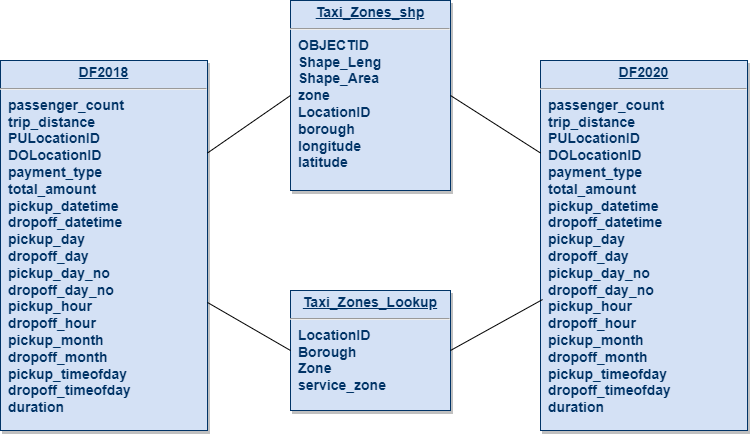

In [5]:
from IPython import display
display.Image("C:/Users/Heni/Desktop/egyetem/BigDataHFDataModel.png")

# Adatok beolvasása eredeti formában

In [3]:
url1="https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-03.csv"
df2018 = pd.read_csv(url1, skipinitialspace=True) # itt most csak olvassuk be az egészet és majd a Data Qualitynál kiszedjük a felesleges oszlopokat
df2018.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-03-01 00:01:34,2018-03-01 00:01:43,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80
1,1,2018-03-01 00:14:34,2018-03-01 00:28:13,1,3.3,1,N,151,244,1,13.0,0.5,0.5,2.85,0.0,0.3,17.15
2,1,2018-03-01 00:51:25,2018-03-01 00:59:54,1,2.7,1,N,238,152,2,10.0,0.5,0.5,0.00,0.0,0.3,11.30
3,1,2018-03-01 00:00:01,2018-03-01 00:00:17,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80
4,1,2018-03-01 00:55:10,2018-03-01 00:56:36,1,3.7,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30


In [4]:
url2="https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-03.csv"
df2020 = pd.read_csv(url2, skipinitialspace=True, low_memory=False)
df2020.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-03-01 00:31:13,2020-03-01 01:01:42,1.0,4.70,1.0,N,88,255,1.0,22.0,3.0,0.5,2.00,0.0,0.3,27.80,2.5
1,2.0,2020-03-01 00:08:22,2020-03-01 00:08:49,1.0,0.00,1.0,N,193,193,2.0,2.5,0.5,0.5,0.00,0.0,0.3,3.80,0.0
2,1.0,2020-03-01 00:52:18,2020-03-01 00:59:16,1.0,1.10,1.0,N,246,90,1.0,6.0,3.0,0.5,1.95,0.0,0.3,11.75,2.5
3,2.0,2020-03-01 00:47:53,2020-03-01 00:50:57,2.0,0.87,1.0,N,151,238,1.0,5.0,0.5,0.5,1.76,0.0,0.3,10.56,2.5
4,1.0,2020-03-01 00:43:19,2020-03-01 00:58:27,0.0,4.40,1.0,N,79,261,1.0,16.5,3.0,0.5,4.05,0.0,0.3,24.35,2.5


In [5]:
print("2018-as adattábla sorainak és oszlopainak száma: {} \n".format(df2018.shape)) #sor és oszlopszám
print("2020-as adattábla sorainak és oszlopainak száma: {} \n".format(df2020.shape))

2018-as adattábla sorainak és oszlopainak száma: (9430376, 17) 

2020-as adattábla sorainak és oszlopainak száma: (3007292, 18) 



In [6]:
print("2018-as adattábla oszloptípusai:")
print("{} \n".format(df2018.dtypes))
print("2020-as adattábla oszloptípusai:")
print("{} \n".format(df2020.dtypes))

2018-as adattábla oszloptípusai:
VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object 

2020-as adattábla oszloptípusai:
VendorID                 float64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type             float64
fare_amount              fl

In [7]:
print("2018-as adatok: \n")
print(df2018.isnull().sum()) # null értékek ellenőrzése, hogy van-e
print("2020-as adatok: \n")
print(df2020.isnull().sum())

2018-as adatok: 

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64
2020-as adatok: 

VendorID                 37487
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          37487
trip_distance                0
RatecodeID               37487
store_and_fwd_flag       37487
PULocationID                 0
DOLocationID                 0
payment_type             37487
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge      

In [8]:
print("2018-as adatok:")
print(df2018.duplicated().sum())
print("2020-as adatok:")
print(df2020.duplicated().sum())

2018-as adatok:
0
2020-as adatok:
0


In [9]:
print("2018-as adatok:")
print(df2018.nunique()) # egyedi értékek száma oszloponként
print("\n2020-as adatok:")
print(df2020.nunique())

2018-as adatok:
VendorID                       2
tpep_pickup_datetime     2358081
tpep_dropoff_datetime    2362057
passenger_count               10
trip_distance               4528
RatecodeID                     7
store_and_fwd_flag             2
PULocationID                 262
DOLocationID                 262
payment_type                   4
fare_amount                 1894
extra                         33
mta_tax                       13
tip_amount                  3534
tolls_amount                1009
improvement_surcharge          4
total_amount               12103
dtype: int64

2020-as adatok:
VendorID                       2
tpep_pickup_datetime     1226256
tpep_dropoff_datetime    1226685
passenger_count               10
trip_distance               3963
RatecodeID                     7
store_and_fwd_flag             2
PULocationID                 260
DOLocationID                 261
payment_type                   4
fare_amount                 6383
extra                        1

In [10]:
print("2018-as adatok:")
df2018.describe()

2018-as adatok:


,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06
mean,1.567604e+00,1.601390e+00,2.864808e+00,1.042197e+00,1.629755e+02,1.611061e+02,1.312569e+00,1.265681e+01,3.343034e-01,4.973344e-01,1.847916e+00,3.253465e-01,3.000036e-01,1.596526e+01
std,4.954086e-01,1.247606e+00,3.722331e+00,4.704546e-01,6.664959e+01,7.051072e+01,4.840774e-01,9.631818e+01,4.645647e-01,7.003697e-02,2.565877e+00,1.663388e+00,1.302640e+00,9.668569e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-3.740000e+02,-6.000000e+01,-5.000000e-01,-8.000000e+01,-3.800000e+01,-3.000000e-01,-3.748000e+02
25%,1.000000e+00,1.000000e+00,9.400000e-01,1.000000e+00,1.140000e+02,1.070000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.300000e+00
50%,2.000000e+00,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,0.000000e+00,5.000000e-01,1.360000e+00,0.000000e+00,3.000000e-01,1.162000e+01
75%,2.000000e+00,2.000000e+00,2.940000e+00,1.000000e+00,2.330000e+02,2.330000e+02,2.000000e+00,1.400000e+01,5.000000e-01,5.000000e-01,2.360000e+00,0.000000e+00,3.000000e-01,1.716000e+01
max,2.000000e+00,9.000000e+00,3.028000e+02,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,2.147484e+05,6.666000e+01,1.500000e+02,4.960000e+02,9.116100e+02,4.000300e+03,2.147502e+05


In [11]:
print("\n2020-as adatok:")
df2020.describe()


2020-as adatok:


,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,2.969805e+06,2.969805e+06,3.007292e+06,2.969805e+06,3.007292e+06,3.007292e+06,2.969805e+06,3.007292e+06,3.007292e+06,3.007292e+06,3.007292e+06,3.007292e+06,3.007292e+06,3.007292e+06,3.007292e+06
mean,1.667242e+00,1.467486e+00,3.116722e+00,1.051378e+00,1.634186e+02,1.609385e+02,1.267743e+00,1.269675e+01,1.246666e+00,6.580587e-01,2.138793e+00,3.041657e-01,2.975907e-01,1.884122e+01,2.241648e+00
std,4.712009e-01,1.120098e+00,2.069343e+02,7.109302e-01,6.658183e+01,7.073925e+01,4.765033e-01,3.871551e+02,2.883275e+02,2.883250e+02,2.719280e+00,1.607296e+00,3.710814e-02,6.945971e+02,7.841027e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.259000e+03,-7.000000e+00,-5.000000e-01,-4.932200e+02,-4.000000e+01,-3.000000e-01,-1.260300e+03,-2.500000e+00
25%,1.000000e+00,1.000000e+00,9.900000e-01,1.000000e+00,1.140000e+02,1.070000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.116000e+01,2.500000e+00
50%,2.000000e+00,1.000000e+00,1.670000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,1.920000e+00,0.000000e+00,3.000000e-01,1.430000e+01,2.500000e+00
75%,2.000000e+00,1.000000e+00,3.020000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.400000e+01,2.500000e+00,5.000000e-01,2.860000e+00,0.000000e+00,3.000000e-01,1.985000e+01,2.500000e+00
max,2.000000e+00,9.000000e+00,2.698037e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,6.711001e+05,5.000008e+05,5.000005e+05,8.000000e+02,6.010200e+02,3.000000e-01,1.000004e+06,2.500000e+00


## Mefigyelések
- A VendorID minimum értéke 1, maximum értéke pedig 2. Ami érthető, hiszen láttuk hogy két fajta vendor ID van a táblázatunkban.
- A Passenger_count minimum értéke 0, ez lehet valamilyen hiba is vagy esetleg egy olyan helyzet amikor a sofőr nem szállított utast.
- Három katerogikus oszlopunk van (RatecodeID, store_and_fwd_flag, payment_type). Ezeknél jól látható, hogy hány típusuk van, ott ahol az oszloponkénti egyedi értékeket vizsgáltuk.
- A két időpontot tartalmazó oszlopunk eredeti formában Object típusúak, amely számunkra nem túl hasznos, hiszen nem tudunk meg belőlük felhasználható adatokat. Így ezeket később még átalakítjuk.
- A total_amount oszlop összegzi az összes értéket azon oszlopokból, amelyek árakat tartalmaznak. Így később csak ezt az oszlopot fogjuk megtartani a vizualizációk során.

### Eltérések
- adattípusok eltérőek, de nincs közöttük olyan eltérés ami elrontani az adatelemzés folyamatát
- A 2020-as adattáblában jóval kevesebb sorunk van mint a 2018-asban. Ami várható volt.
- A 2020-as táblában vannak null értékek míg a 2018-asban nem. De ezen null értékeket a Data Quality check során eltávolítjuk. SZámszerűen 37.487 sort.


# Lookup table a taxi zónákhoz

In [12]:
url3 = "https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv"
df_taxi_zones = pd.read_csv(url3, skipinitialspace=True)
df_taxi_zones.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [13]:
df_taxi_zones.shape

(265, 4)

In [14]:
df_taxi_zones.isnull().sum()

LocationID      0
Borough         0
Zone            1
service_zone    2
dtype: int64

In [15]:
df_taxi_zones = df_taxi_zones.dropna(axis=0, how='any')

## Megjegyzés: 
Észrevettük, hogy két sor az id-n kivul ugyanolyan adatokat tárol a Borough/Zone oszlopokban, csak más id-val \
A kettő megkülönböztetése érdekében és a térképen elfoglalt helyzetük alapján szerkesztettük ezt a forrásfájlt, és a neveket a következőre változtattuk: \
- id 56 --> Corona (South)
- id 57 --> Corona (East)

Valamint észrevettük, hogy két sora tartalmaz null értéket. Ezen két sor a 264, és a 265-ös ID-jú sor, így ezeket töröltük ezen táblázatból.

# Data Quality check and data preparation

### Nan értékek törlése 
Ki akartuk szedni a táblából azon sorokat, amelyek bármely tulajdonságuknál Nan értéket tartalmaztak, azaz nem tartalmaztak értelmezhető adatot. \
Valamint, hogy megfelelően lehessen majd illeszteni a táblákat a lookup taxi zónás táblához. Leellenőriztük, hogy a táblában csak megfelelő Location ID-k szerepeljenek. Azaz töröltük azon sorokat amelyeknél vagy 264 vagy 265-s érték szerepelt bármely LocationID-s oszlopukban, hiszen ezen pozíciókhoz nincs értelmes adatunk a taxi zónás lookup táblánkban.

In [16]:
df2018 = df2018.dropna(axis=0, how='any') #itt kidobom az osszes olyan sort amiben valahol is van Nan érték
df2020 = df2020.dropna(axis=0, how='any')

In [17]:
#Nem ismert LocationID-k törlése
PU_NaN_condition = df2018[df2018['PULocationID'].isin(['264', '265'])].index
df2018 = df2018.drop(PU_NaN_condition)
DO_NaN_condition = df2018[df2018['DOLocationID'].isin(['264', '265'])].index
df2018 = df2018.drop(DO_NaN_condition)
PU_NaN_condition = df2020[df2020['PULocationID'].isin(['264', '265'])].index
df2020 = df2020.drop(PU_NaN_condition)
DO_NaN_condition = df2020[df2020['DOLocationID'].isin(['264', '265'])].index
df2020 = df2020.drop(DO_NaN_condition)

## Dátum és idő oszlop kezelése
Az eredeti táblában az utasok felvételi és kiszállási ideje Objectként van eltárolva. \
Úgy gondoltuk, hogy hasznos lenne feldarabolni ezen oszlopot, hogy plusz adatokra tehessünk szert mint például az idő és a dátum szétszedése. \
Ennek segítségével például meg tudjuk majd később különböztetni, hogy a hét mely napjáról van szó vagy ki tudjuk számolni, hogy mennyi időt ölelt fel az utazás.

In [18]:
# oszloptípus konvertálása datetime-ba
df2018['pickup_datetime']=pd.to_datetime(df2018['tpep_pickup_datetime'])
df2018['dropoff_datetime']=pd.to_datetime(df2018['tpep_dropoff_datetime'])
df2020['pickup_datetime']=pd.to_datetime(df2020['tpep_pickup_datetime'])
df2020['dropoff_datetime']=pd.to_datetime(df2020['tpep_dropoff_datetime'])
df2018.dtypes

VendorID                          int64
tpep_pickup_datetime             object
tpep_dropoff_datetime            object
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
pickup_datetime          datetime64[ns]
dropoff_datetime         datetime64[ns]
dtype: object

In [19]:
#új oszlopok és adatok létrehozása a datetime típusú oszlopokból
df2018['pickup_day']=df2018['pickup_datetime'].dt.day_name()
df2018['dropoff_day']=df2018['dropoff_datetime'].dt.day_name()
df2020['pickup_day']=df2020['pickup_datetime'].dt.day_name()
df2020['dropoff_day']=df2020['dropoff_datetime'].dt.day_name()

df2018['pickup_day_no']=df2018['pickup_datetime'].dt.weekday
df2018['dropoff_day_no']=df2018['dropoff_datetime'].dt.weekday
df2020['pickup_day_no']=df2020['pickup_datetime'].dt.weekday
df2020['dropoff_day_no']=df2020['dropoff_datetime'].dt.weekday

df2018['pickup_hour']=df2018['pickup_datetime'].dt.hour
df2018['dropoff_hour']=df2018['dropoff_datetime'].dt.hour
df2020['pickup_hour']=df2020['pickup_datetime'].dt.hour
df2020['dropoff_hour']=df2020['dropoff_datetime'].dt.hour

df2018['pickup_month']=df2018['pickup_datetime'].dt.month
df2018['dropoff_month']=df2018['dropoff_datetime'].dt.month
df2020['pickup_month']=df2020['pickup_datetime'].dt.month
df2020['dropoff_month']=df2020['dropoff_datetime'].dt.month

Hogy meghatározzuk, hogy a nap mely szakaszában történt az utazás, 4 időzónát hoztunk létre a következő függvény segítségével.

In [20]:
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

In [21]:
df2018['pickup_timeofday']=df2018['pickup_hour'].apply(time_of_day)
df2018['dropoff_timeofday']=df2018['dropoff_hour'].apply(time_of_day)
df2020['pickup_timeofday']=df2020['pickup_hour'].apply(time_of_day)
df2020['dropoff_timeofday']=df2020['dropoff_hour'].apply(time_of_day)

In [22]:

duration_dt18 = (df2018['dropoff_datetime']) - (df2018['pickup_datetime'])
totalseconds18 = duration_dt18.dt.total_seconds()
minutes18 = totalseconds18 / 60
df2018['duration'] = minutes18
#df2018['duration_dt'] = duration_dt18
#df2018['duration_seconds'] = totalseconds18

duration_dt20 = (df2020['dropoff_datetime']) - (df2020['pickup_datetime'])
totalseconds20 = duration_dt20.dt.total_seconds()
minutes20 = totalseconds20 / 60
df2020['duration'] = minutes20


In [23]:
df2018.dtypes

VendorID                          int64
tpep_pickup_datetime             object
tpep_dropoff_datetime            object
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
pickup_datetime          datetime64[ns]
dropoff_datetime         datetime64[ns]
pickup_day                       object
dropoff_day                      object
pickup_day_no                     int64
dropoff_day_no                    int64
pickup_hour                       int64
dropoff_hour                      int64


In [24]:
df2018.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,dropoff_day,pickup_day_no,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,pickup_timeofday,dropoff_timeofday,duration
9430371,2,2018-03-31 23:34:47,2018-03-31 23:55:17,5,4.11,1,N,186,263,1,...,Saturday,5,5,23,23,3,3,Late night,Late night,20.500000
9430372,2,2018-03-31 23:02:38,2018-03-31 23:13:10,6,1.50,1,N,100,107,1,...,Saturday,5,5,23,23,3,3,Late night,Late night,10.533333
9430373,2,2018-03-31 23:15:58,2018-03-31 23:30:29,6,2.07,1,N,107,170,2,...,Saturday,5,5,23,23,3,3,Late night,Late night,14.516667
9430374,1,2018-03-31 23:05:37,2018-03-31 23:18:31,2,1.60,1,N,163,164,2,...,Saturday,5,5,23,23,3,3,Late night,Late night,12.900000
9430375,1,2018-03-31 23:37:11,2018-03-31 23:56:53,1,3.90,1,N,144,161,2,...,Saturday,5,5,23,23,3,3,Late night,Late night,19.700000


In [25]:
df2018.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
pickup_datetime          0
dropoff_datetime         0
pickup_day               0
dropoff_day              0
pickup_day_no            0
dropoff_day_no           0
pickup_hour              0
dropoff_hour             0
pickup_month             0
dropoff_month            0
pickup_timeofday         0
dropoff_timeofday        0
duration                 0
dtype: int64

In [33]:
# fölösleges oszlopok törlése
df2018 = df2018.drop(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID', 'store_and_fwd_flag', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge'], axis=1)
df2020 = df2020.drop(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID', 'store_and_fwd_flag', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge'], axis=1)

In [34]:
print('Proportion of trips without any passenger in 2018')
ratio = df2018[df2018['passenger_count']==0].shape[0]/df2018.shape[0]*100

print("{:.2f}".format(ratio),'%')

print('\nProportion of trips without any passenger in 2020')
ratio = df2020[df2020['passenger_count']==0].shape[0]/df2020.shape[0]*100

print("{:.2f}".format(ratio),'%')


Proportion of trips without any passenger in 2018
0.70 %

Proportion of trips without any passenger in 2020
2.13 %


In [35]:
#két dataframe létrehozása. Egyikben kiszedjük azokat az utakat ahol 0 utas volt.
no_pass_condition = df2018[df2018['passenger_count'] == 0].index
df2018_full = df2018.drop(no_pass_condition)
df2018_empty = df2018[df2018['passenger_count']==0]

no_pass_condition = df2020[df2020['passenger_count'] == 0].index
df2020_full = df2020.drop(no_pass_condition)
df2020_empty = df2018[df2018['passenger_count']==0]

In [36]:
df2018_full.shape

(9174942, 19)

In [37]:
df2018_empty.shape

(64489, 19)

# Vizualizációk

In [38]:
df2018.columns

Index(['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'payment_type', 'total_amount', 'pickup_datetime', 'dropoff_datetime',
       'pickup_day', 'dropoff_day', 'pickup_day_no', 'dropoff_day_no',
       'pickup_hour', 'dropoff_hour', 'pickup_month', 'dropoff_month',
       'pickup_timeofday', 'dropoff_timeofday', 'duration'],
      dtype='object')

In [41]:
df2018.passenger_count.value_counts()

1    6574622
2    1352870
5     433356
3     381713
6     255688
4     176646
0      64489
7         21
8         18
9          8
Name: passenger_count, dtype: int64

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

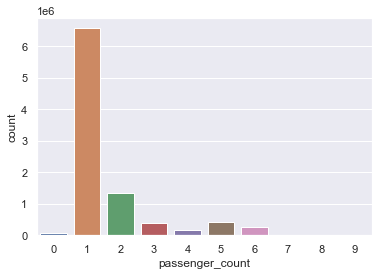

In [42]:
sns.countplot(x='passenger_count',data=df2018)

In [6]:
sns.countplot(x='passenger_count',data=df2020)

NameError: name 'df2020' is not defined

In [43]:
df2018=df2018[df2018['passenger_count']!=0]
df2018=df2018[df2018['passenger_count']<=6]

df2020=df2020[df2020['passenger_count']!=0]
df2020=df2020[df2020['passenger_count']<=6]

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

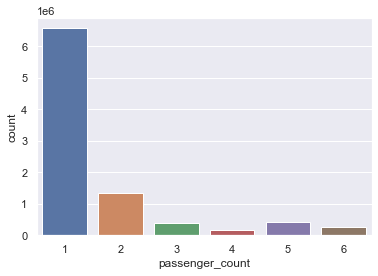

In [44]:
sns.countplot(x='passenger_count',data=df2018)

In [ ]:
sns.countplot(x='passenger_count',data=df2020)

In [45]:
df2018['trip_distance'].value_counts()

0.80     209274
0.90     208403
1.00     203209
0.70     201153
1.10     191413
          ...  
48.42         1
32.88         1
32.62         1
32.38         1
35.63         1
Name: trip_distance, Length: 3722, dtype: int64

In [ ]:
df2020['trip_distance'].value_counts()

## Trips per Day

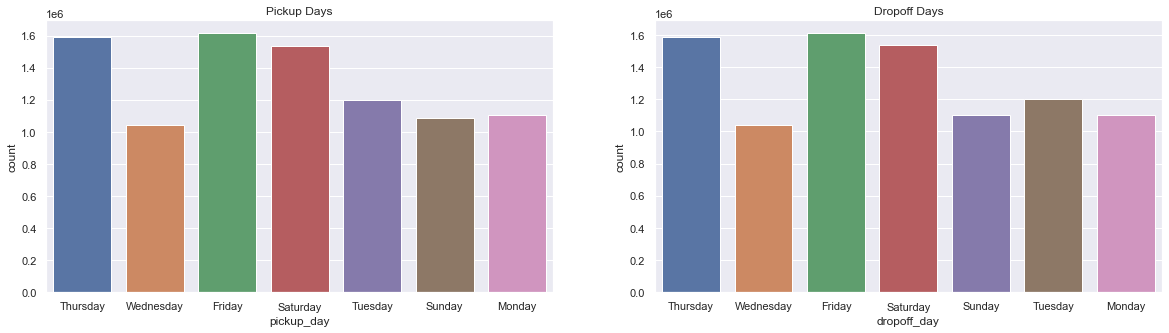

In [46]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))

ax1.set_title('Pickup Days in 2018')
ax=sns.countplot(x="pickup_day",data=df2018,ax=ax1)

ax2.set_title('Dropoff Days in 2018')
ax=sns.countplot(x="dropoff_day",data=df2018,ax=ax2)

In [ ]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))

ax1.set_title('Pickup Days in 2020')
ax=sns.countplot(x="pickup_day",data=df2020,ax=ax1)

ax2.set_title('Dropoff Days in 2020')
ax=sns.countplot(x="dropoff_day",data=df2020,ax=ax2)

## Trips per Hour

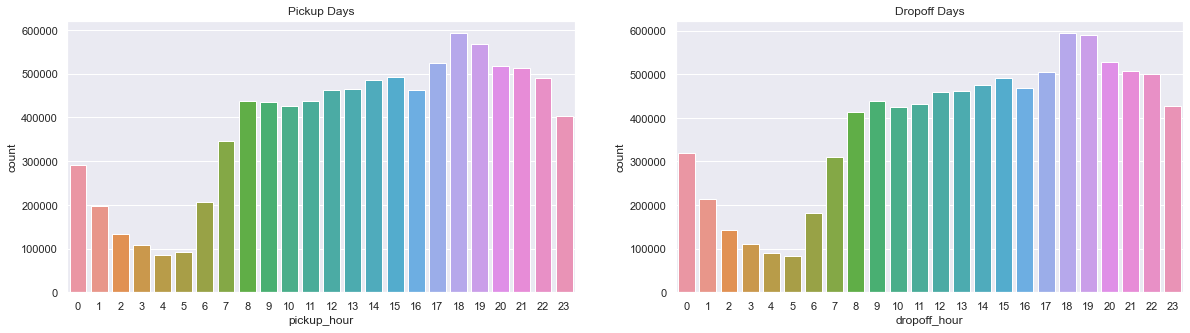

In [47]:
figure,(ax9,ax10)=plt.subplots(ncols=2,figsize=(20,5))

ax9.set_title('Pickup Days in 2018')
ax=sns.countplot(x="pickup_hour",data=df2018,ax=ax9)

ax10.set_title('Dropoff Days in 2018')
ax=sns.countplot(x="dropoff_hour",data=df2018,ax=ax10)

In [ ]:
figure,(ax9,ax10)=plt.subplots(ncols=2,figsize=(20,5))

ax9.set_title('Pickup Days in 2020')
ax=sns.countplot(x="pickup_hour",data=df2020,ax=ax9)

ax10.set_title('Dropoff Days in 2020')
ax=sns.countplot(x="dropoff_hour",data=df2020,ax=ax10)

## Trips per Time of Day

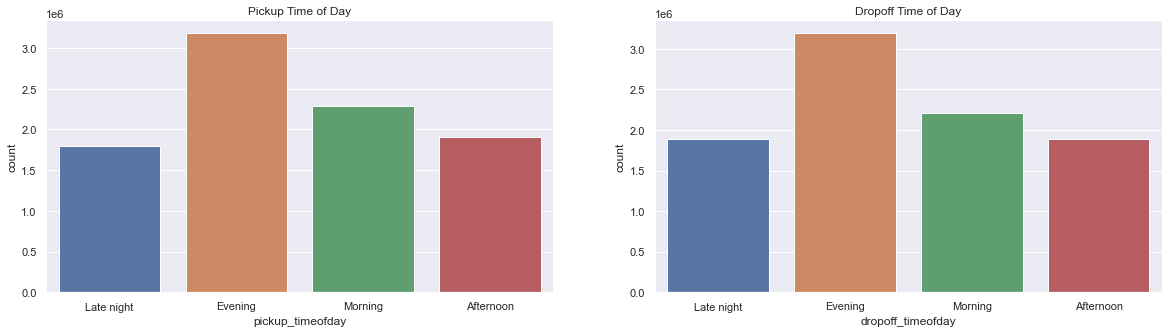

In [48]:
figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))

ax3.set_title('Pickup Time of Day in 2018')
ax=sns.countplot(x="pickup_timeofday",data=df2018,ax=ax3)

ax4.set_title('Dropoff Time of Day in 2018')
ax=sns.countplot(x="dropoff_timeofday",data=df2018,ax=ax4)

In [ ]:
figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))

ax3.set_title('Pickup Time of Day in 2020')
ax=sns.countplot(x="pickup_timeofday",data=df2020,ax=ax3)

ax4.set_title('Dropoff Time of Day in 2020')
ax=sns.countplot(x="dropoff_timeofday",data=df2020,ax=ax4)

## Trip duration per hour
Látható, hogy az utazási idő délután 3,4 óra körül és a leghosszabb. Ennek oka esetleg a délután esti forgalom lehet.

<AxesSubplot:xlabel='pickup_hour', ylabel='duration'>

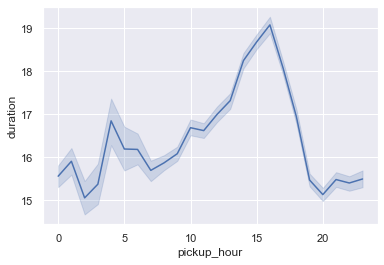

In [49]:
sns.lineplot(x='pickup_hour',y='duration',data=df2018)

In [ ]:
sns.lineplot(x='pickup_hour',y='duration',data=df2020)

## Trip duration per Day of Week

<AxesSubplot:xlabel='pickup_day_no', ylabel='duration'>

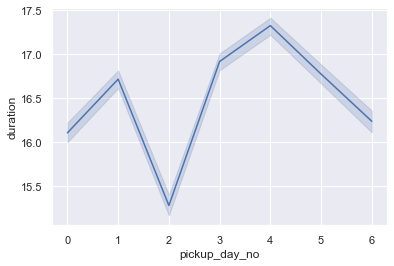

In [50]:
sns.lineplot(x='pickup_day_no',y='duration',data=df2018)

In [ ]:
sns.lineplot(x='pickup_day_no',y='duration',data=df2020)

# HeatMap

In [51]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])


In [52]:
sf = shapefile.Reader("C:/Users/Heni/Desktop/egyetem/7_felev/BigData/taxi_zones/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


In [53]:
result = pd.merge(df2020,
                 df_loc[['Shape_Leng','Shape_Area','zone','LocationID','borough' ,'longitude' ,'latitude']],
                 left_on='PULocationID',
                 right_on='LocationID',
                 how='left')
result.rename(columns={"LocationID":"NewPULocationID","borough":"PUBorough","zone":"PUZone","Shape_Leng":"PUShape_Leng","Shape_Area":"PUShape_Area","longitude":"PULongitude","latitude":"PULatitude"}, inplace = True)
result.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,pickup_timeofday,dropoff_timeofday,duration,PUShape_Leng,PUShape_Area,PUZone,NewPULocationID,PUBorough,PULongitude,PULatitude
0,1.0,2020-03-01 00:31:13,2020-03-01 01:01:42,1.0,4.70,1.0,N,88,255,1.0,...,Late night,Late night,30.483333,0.035205,0.000057,Financial District South,88.0,Manhattan,9.811971e+05,195500.411846
1,2.0,2020-03-01 00:08:22,2020-03-01 00:08:49,1.0,0.00,1.0,N,193,193,2.0,...,Late night,Late night,0.450000,0.065530,0.000146,Queensbridge/Ravenswood,193.0,Queens,1.000209e+06,216823.904907
2,1.0,2020-03-01 00:52:18,2020-03-01 00:59:16,1.0,1.10,1.0,N,246,90,1.0,...,Late night,Late night,6.966667,0.069467,0.000281,West Chelsea/Hudson Yards,246.0,Manhattan,9.831937e+05,213400.586465
3,2.0,2020-03-01 00:47:53,2020-03-01 00:50:57,2.0,0.87,1.0,N,151,238,1.0,...,Late night,Late night,3.066667,0.054890,0.000129,Manhattan Valley,151.0,Manhattan,9.930484e+05,229960.162885
4,1.0,2020-03-01 00:43:19,2020-03-01 00:58:27,0.0,4.40,1.0,N,79,261,1.0,...,Late night,Late night,15.133333,0.042625,0.000108,East Village,79.0,Manhattan,9.883201e+05,204490.058251


In [54]:
df2020joined = pd.merge(result,
                df_loc[['Shape_Leng','Shape_Area','zone','LocationID','borough' ,'longitude' ,'latitude']],
                 left_on='DOLocationID',
                 right_on='LocationID',
                 how='left')

df2020joined.rename(columns={"LocationID":"NewDOLocationID","borough":"DOBorough","zone":"DOZone","Shape_Leng":"DOShape_Leng","Shape_Area":"DOShape_Area","longitude":"DOLongitude","latitude":"DOLatitude"}, inplace = True)
df2020joined.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,PUBorough,PULongitude,PULatitude,DOShape_Leng,DOShape_Area,DOZone,NewDOLocationID,DOBorough,DOLongitude,DOLatitude
0,1.0,2020-03-01 00:31:13,2020-03-01 01:01:42,1.0,4.70,1.0,N,88,255,1.0,...,Manhattan,9.811971e+05,195500.411846,0.062384,0.000172,Williamsburg (North Side),255.0,Brooklyn,9.960899e+05,201154.900463
1,2.0,2020-03-01 00:08:22,2020-03-01 00:08:49,1.0,0.00,1.0,N,193,193,2.0,...,Queens,1.000209e+06,216823.904907,0.065530,0.000146,Queensbridge/Ravenswood,193.0,Queens,1.000209e+06,216823.904907
2,1.0,2020-03-01 00:52:18,2020-03-01 00:59:16,1.0,1.10,1.0,N,246,90,1.0,...,Manhattan,9.831937e+05,213400.586465,0.030759,0.000055,Flatiron,90.0,Manhattan,9.850892e+05,209710.350017
3,2.0,2020-03-01 00:47:53,2020-03-01 00:50:57,2.0,0.87,1.0,N,151,238,1.0,...,Manhattan,9.930484e+05,229960.162885,0.060109,0.000185,Upper West Side North,238.0,Manhattan,9.917176e+05,227746.100420
4,1.0,2020-03-01 00:43:19,2020-03-01 00:58:27,0.0,4.40,1.0,N,79,261,1.0,...,Manhattan,9.883201e+05,204490.058251,0.027120,0.000034,World Trade Center,261.0,Manhattan,9.807446e+05,197628.272456


In [55]:
result = pd.merge(df2018,
                 df_loc[['Shape_Leng','Shape_Area','zone','LocationID','borough' ,'longitude' ,'latitude']],
                 left_on='PULocationID',
                 right_on='LocationID',
                 how='left')
result.rename(columns={"LocationID":"NewPULocationID","borough":"PUBorough","zone":"PUZone","Shape_Leng":"PUShape_Leng","Shape_Area":"PUShape_Area","longitude":"PULongitude","latitude":"PULatitude"}, inplace = True)
result.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,pickup_datetime,dropoff_datetime,pickup_day,dropoff_day,...,pickup_timeofday,dropoff_timeofday,duration,PUShape_Leng,PUShape_Area,PUZone,NewPULocationID,PUBorough,PULongitude,PULatitude
0,1,0.0,145,145,2,3.80,2018-03-01 00:01:34,2018-03-01 00:01:43,Thursday,Thursday,...,Late night,Late night,0.150000,0.114314,0.000347,Long Island City/Hunters Point,145.0,Queens,998207.572970,211280.687978
1,1,3.3,151,244,1,17.15,2018-03-01 00:14:34,2018-03-01 00:28:13,Thursday,Thursday,...,Late night,Late night,13.650000,0.054890,0.000129,Manhattan Valley,151.0,Manhattan,993048.448746,229960.162885
2,1,2.7,238,152,2,11.30,2018-03-01 00:51:25,2018-03-01 00:59:54,Thursday,Thursday,...,Late night,Late night,8.483333,0.060109,0.000185,Upper West Side North,238.0,Manhattan,991717.634231,227746.100420
3,1,0.0,145,145,2,3.80,2018-03-01 00:00:01,2018-03-01 00:00:17,Thursday,Thursday,...,Late night,Late night,0.266667,0.114314,0.000347,Long Island City/Hunters Point,145.0,Queens,998207.572970,211280.687978
4,1,3.7,145,145,2,4.30,2018-03-01 00:55:10,2018-03-01 00:56:36,Thursday,Thursday,...,Late night,Late night,1.433333,0.114314,0.000347,Long Island City/Hunters Point,145.0,Queens,998207.572970,211280.687978


In [56]:
df2018joined = pd.merge(result,
                df_loc[['Shape_Leng','Shape_Area','zone','LocationID','borough' ,'longitude' ,'latitude']],
                 left_on='DOLocationID',
                 right_on='LocationID',
                 how='left')

df2018joined.rename(columns={"LocationID":"NewDOLocationID","borough":"DOBorough","zone":"DOZone","Shape_Leng":"DOShape_Leng","Shape_Area":"DOShape_Area","longitude":"DOLongitude","latitude":"DOLatitude"}, inplace = True)
df2018joined.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,total_amount,pickup_datetime,dropoff_datetime,pickup_day,dropoff_day,...,PUBorough,PULongitude,PULatitude,DOShape_Leng,DOShape_Area,DOZone,NewDOLocationID,DOBorough,DOLongitude,DOLatitude
0,1,0.0,145,145,2,3.80,2018-03-01 00:01:34,2018-03-01 00:01:43,Thursday,Thursday,...,Queens,998207.572970,211280.687978,0.114314,0.000347,Long Island City/Hunters Point,145.0,Queens,9.982076e+05,211280.687978
1,1,3.3,151,244,1,17.15,2018-03-01 00:14:34,2018-03-01 00:28:13,Thursday,Thursday,...,Manhattan,993048.448746,229960.162885,0.080569,0.000360,Washington Heights South,244.0,Manhattan,1.000637e+06,245752.655290
2,1,2.7,238,152,2,11.30,2018-03-01 00:51:25,2018-03-01 00:59:54,Thursday,Thursday,...,Manhattan,991717.634231,227746.100420,0.057909,0.000147,Manhattanville,152.0,Manhattan,9.969668e+05,237124.584084
3,1,0.0,145,145,2,3.80,2018-03-01 00:00:01,2018-03-01 00:00:17,Thursday,Thursday,...,Queens,998207.572970,211280.687978,0.114314,0.000347,Long Island City/Hunters Point,145.0,Queens,9.982076e+05,211280.687978
4,1,3.7,145,145,2,4.30,2018-03-01 00:55:10,2018-03-01 00:56:36,Thursday,Thursday,...,Queens,998207.572970,211280.687978,0.114314,0.000347,Long Island City/Hunters Point,145.0,Queens,9.982076e+05,211280.687978


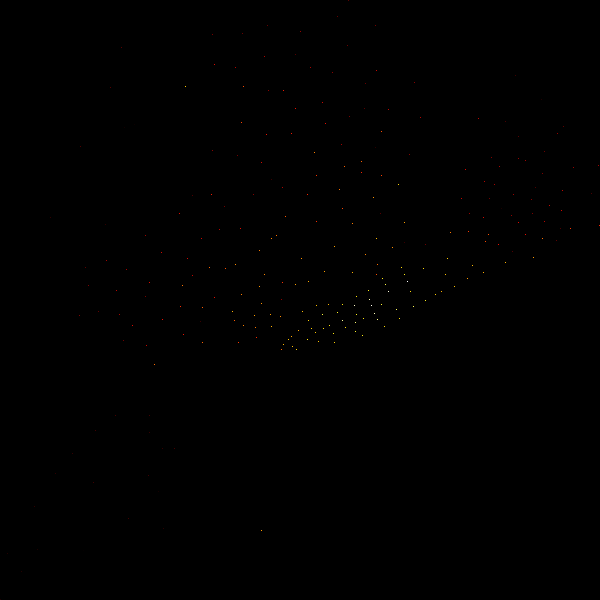

In [57]:
agg = ds.Canvas().points(df2018joined, 'DOLatitude', 'DOLongitude')
ds.tf.set_background(ds.tf.shade(agg, cmap=cc.fire), "black")

In [61]:
import holoviews as hv
from holoviews.element.tiles import EsriImagery
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

map_tiles  = EsriImagery().opts(alpha=0.5, width=900, height=480, bgcolor='black')
points     = hv.Points(df2018joined, ['DOLatitude', 'DOLongitude'])
taxi_trips = datashade(points, x_sampling=1, y_sampling=1, cmap=cc.fire, width=900, height=480)

map_tiles * taxi_trips

ImportError: cannot import name 'TypeGuard' from 'typing_extensions' (C:\Users\Heni\anaconda3\lib\site-packages\typing_extensions.py)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

df2018joined.plot(kind='scatter', x='PULongitude', y='PULatitude',
color='yellow',
s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

df2018joined.plot(kind='scatter', x='DOLongitude', y='DOLatitude',
color='yellow',
s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black')